# Lidar data × Python Tutorial Session 2. ～点群データのラスター化～

チュートリアルではPythonを使用してLidarのデータ処理について学んでいきます。第2回のこのセッションでは、点群データからラスターデータへの変換について学んでいきます。
---

Section1.
 - ラスターデータとは

 - 画像データの概要

 - 白黒画像の構成要素


Section2.
 - DTMとは
 
 - サンプル範囲の点群データ断面図

 - CSFアルゴリズム

 - DTMの作成と出力

 - DTMの可視化


Section3.
 - DSMとは

 

おわりに.

In [ ]:
# # 最初にこのセルを実行すると、一度セッションが再起動される。再起動されたら、次のセルを実行してもよい。
# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [ ]:
# 今回のチュートリアルに必要なライブラリをインストールする。
# これも実行すると再起動がかかるかもしれないが、その後下のセルを実行する事が出来る。
!conda update -y -n base -c defaluts conda
!conda install --channel conda-forge pdal
!pip install PDAL open3d polars japanize_matplotlib folium mapclassify pyproj

In [1]:
import json
import os
from pprint import pprint

import geopandas as gpd
# from google.colab import drive
import japanize_matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pdal
import pyproj
import shapely
from shapely.plotting import plot_polygon

# GoogleDriveをマウント
# drive.mount('/content/drive')

# Section1.
3Dでビジュアライズするのであれば、点群データのままの方がいいでしょう。しかし、樹頂点を検出するなどの場合は3次元データをそのまま使用するよりも、2次元データに変換する方が、計算が単純になります。

このセクションでは3次元データから2次元データへの変換先である<b>`ラスターデータ（Raster Data）`</b>について解説していきます。

## ラスター（Raster）とは何なのか
---
DTMなどをファイルとして保存する場合は`.tif(.tiff)`ファイルとして保存する事が多いでしょう。**`Tiff(Tagged Image File Format)`**とは画像データを保存する為に使用するファイル形式です。非圧縮または可逆圧縮でファイルを保存するので、画像の品質を落とさずに高解像度の画像を扱う事が出来ます。つまりキレイな画像なのですが、GISではこれらの画像データを**`Raster Data(ラスターデータ)`**と呼びます。

DTMの処理をする前に、まずはこの画像データについて解説していきます。この場で各フォーマットに対し詳しい解説をするわけではありません。そもそも画像とはどんなデータ構造になっているのか、について解説していきます。これがわかる方はここを飛ばしても構いません。

### 画像の概要
PCなどで画像ファイルの詳細を見ると、画像のサイズが書かれていると思います。

大きさ: 100 × 200

幅　　: 100

高さ　: 200

これは行方向（横）にいくつのセルが並んでいるか、列方向にいくつのセルが並んでいるか、を表します。

セルとは画像を構成する小さな四角いマスの事です。

Excelで考えるとわかりやすいかと思います。`Sheet1`に対して100行200列の範囲に罫線を引き、列幅を調節して、辺の長さをそろえると画像の骨組みを作る事が出来ます。

Excelでも1つのセルには数値が1つしか入りません、句読点を入れてしまうとそれは数値ではなく数字の文字列になります。画像も同じ様に、1つのセルには1つの数値が入力されており、この数値の大小で画像は色を表現しています。


### 白黒画像の構成
---
一番イメージしやすいのが、白黒画像です。この構成はDTMなどと同じなので、ここを読んで理解を深めて下さい。

白黒画像は上記で解説したとおり、数値が入力された2次元行列のデータとして考える事が出来ます。

実際に行列を用意して可視化してイメージを確認してみましょう。以下のコードでは実際に白黒画像を作成して、そのデータを可視化させています。数値が高い場所は白く、数値が低い場所は黒く表示されているのがわかると思います。

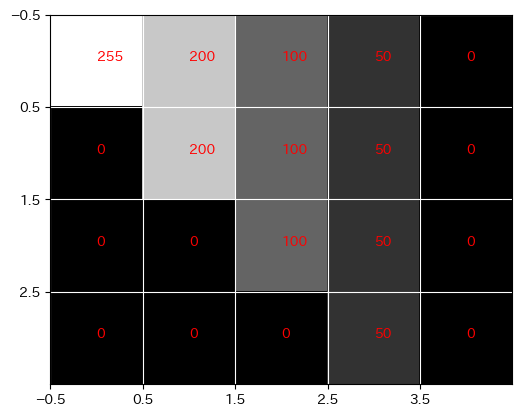

In [2]:
# ここでは8bit(2の8乗)の画像を例に考えます。
# 下の`img`に代入した配列が画像のデータです。
img = np.array([
    [255, 200, 100, 50, 0],
    [0  , 200, 100, 50, 0],
    [0  ,   0, 100, 50, 0],
    [0  ,   0,   0, 50, 0],
])

plt.imshow(img, cmap='gray')
for xc in list(range(0, 5)):
    for yc in list(range(0, 4)):
        plt.text(xc, yc, img[yc][xc], color='red')

plt.yticks(np.arange(-0.5, 3.5, 1))
plt.xticks(np.arange(-0.5, 4.5, 1))
plt.grid(color='white');

ラスターデータは、上記のように行と列の格子状に並んだセル（ピクセル）で構成されます。各セルには数値が入力されており、この数値で要素を表現します。このデータをメッシュデータ、またはグリッドデータと呼ぶ事もあります。DTMの場合はこのセルに地形の高さ（m）が入力されています。

## DTMの作成
---
実際に点群データからDTMを作成してみたいのですが、ここで問題が生じます。点群データの中には地面のデータだけではなく、様々な物体に反射した点群が含まれています。

イメージを確認する為に、実際に点群データの範囲内に1m幅のサンプル帯を作成し、そこにある点群を可視化してみましょう。

In [2]:
# 出力した新たなデータを読み込む
OUT_FILE_LAS = r'../datasets/Izu_proj.las'

sentence = {
    'pipeline': [
        {
            'type': 'readers.las',
            'filename': OUT_FILE_LAS,
        }
    ]
}
json_sentence = json.dumps(sentence)

pipeline = pdal.Pipeline(json_sentence)
pipeline.execute()

# DataFrame化
ary = pipeline.arrays[0]
df = gpd.GeoDataFrame(ary)
df.head(3)

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,Synthetic,KeyPoint,Withheld,Overlap,ScanAngleRank,UserData,PointSourceId,GpsTime,Red,Green,Blue
0,33100.84,-124484.26,637.23,682,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,23130,31097,23901
1,33104.73,-124483.58,637.76,1024,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,32125,37522,26214
2,33104.46,-124481.53,636.75,986,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,10537,16191,13364


In [4]:
df.iloc[:, : 4].head(10)

,X,Y,Z,Intensity
0,33100.84,-124484.26,637.23,682
1,33104.73,-124483.58,637.76,1024
2,33104.46,-124481.53,636.75,986
3,33100.13,-124486.60,638.52,1011
4,33101.58,-124487.81,639.45,1419
5,33100.08,-124481.18,638.53,724
6,33106.38,-124485.86,639.53,812
7,33107.78,-124483.06,638.52,870
8,33105.53,-124480.40,639.51,397
9,33111.32,-124480.48,638.40,1132


In [5]:
df.describe()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,Synthetic,KeyPoint,Withheld,Overlap,ScanAngleRank,UserData,PointSourceId,GpsTime,Red,Green,Blue
count,2.235028e+07,2.235028e+07,2.235028e+07,2.235028e+07,22350278.0,22350278.0,22350278.0,22350278.0,22350278.0,22350278.0,22350278.0,22350278.0,22350278.0,22350278.0,22350278.0,22350278.0,22350278.0,2.235028e+07,2.235028e+07,2.235028e+07
mean,3.317588e+04,-1.244102e+05,6.400107e+02,1.152479e+03,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,3.064287e+04,3.453091e+04,2.498870e+04
std,4.209407e+01,5.123267e+01,1.510801e+01,3.402589e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.695252e+03,7.690594e+03,5.246819e+03
min,3.310000e+04,-1.245300e+05,5.933200e+02,8.300000e+01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,5.140000e+03,7.453000e+03,7.453000e+03
25%,3.313959e+04,-1.244471e+05,6.289000e+02,9.870000e+02,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,2.570000e+04,2.981200e+04,2.133100e+04
50%,3.317472e+04,-1.244101e+05,6.390400e+02,1.231000e+03,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,3.135400e+04,3.546600e+04,2.518600e+04
75%,3.321214e+04,-1.243714e+05,6.508800e+02,1.400000e+03,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,3.623700e+04,4.009200e+04,2.878400e+04
max,3.325000e+04,-1.243100e+05,6.814600e+02,3.505000e+03,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,5.782500e+04,5.602600e+04,5.525500e+04


In [ ]:
# 帯の作成
max_x, min_x = df['X'].max(), df['X'].min()
max_y, min_y = df['Y'].max(), df['Y'].min()
sample_y = (max_y - min_y) / 2 + min_y
sample_box = (
    shapely
    .LineString([
        [min_x, sample_y],
        [max_x, sample_y]
    ])
    .buffer(0.5, cap_style='flat')
)

box = shapely.box(min_x, min_y, max_x, max_y)
# 帯の可視化
fig, ax = plt.subplots()
plot_polygon(box, ax=ax, label='計測範囲')
plot_polygon(sample_box, color='red', add_points=False, ax=ax, label='サンプル')
ax.legend()

In [ ]:
# geopandas.GeoSeriesの作成
geoms = gpd.points_from_xy(x=df['X'], y=df['Y'], z=df['Z'], crs=IN_SRS_PS)

# サンプル内のデータに絞り込む
select_geoms = geoms[sample_box.intersects(geoms)]
print(f"サンプル内の点数: {len(select_geoms)}")

In [ ]:
# データの可視化
x = select_geoms.x
z = select_geoms.z
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(x, z, s=1)
ax.set_title('サンプル内の点群データ')
ax.set_xlabel('X座標')
ax.set_ylabel('高さ');

上記の散布図を見て見ると樹冠や幹、地面など様々なデータが取得できている事が確認できます。

しかし`DTM`を作成する場合は、この中から地面のデータだけを抽出する必要があります。

どの様にすれば地面のデータだけを抽出する事が出来るのでしょうか。

### CSF(Cloth Simulation Filter)アルゴリズムによる点群分類
---
ここでは`Cloud Compare`でも使用されている`CSF`について簡単に解説します。

`CSF`は点群データを「地面点」か「非地面点」に分類する為のアルゴリズムです。このアルゴリズムではクロス（Cloth : 布）を使用して地面を分類します。

<b>1. 計測データの反転 ... </b>まずは計測した点群データの上下を反転させます。レーザーは光なので、物体を透過する事はありません。したがって、樹冠や幹、地面などの表面に当たり反射したものが計測され記録されています。このデータを反転させ、ある断面を見てみると、物体があった場所には穴のような凹みが現れるでしょう（下図参照）。

<b>2. クロスシュミレーション ... </b>反転したデータに対して、布を被せる様な計算を行う事で地面の位置を予測します。データを反転した際に出来た凹みは、現実世界と同じ様に布を被せても布が凹みの穴に落ちて行くことはありません。

<b>3. 布の大きさ（解像度 : resolution） ... </b>単純に全体に対して布を被せるわけではありません。布の大きさを指定し（例えば 1m × 1m）その布をずらしながら、何度も被せて全体の分類を行います。この布の大きさは非常に重要で、小さくし過ぎると布が凹みの中に落ちてしまいますし、大きくし過ぎると、詳細な地形を作成する事が出来ません。このパラメーターを決める場合は、現地の状況を考慮して考える必要があります。

<b>4. 布の硬さ（剛性 : rigidness） ... </b>布の柔らかさで「どれくらい地面に沿わせるか」を決定します。現実世界に照らして考えると、非常に柔らかい布は、小さな凹みであってもそれを捉え、布の中央が凹んでしまう、あるいは落ちてしまいます。逆に硬くし過ぎると、それは布ではなく、板になってしまい、滑らかな地形のデータを作成する事が出来なくなります。

<b>5. 分類閾値（threshold） ... </b>実際に"作成した布"と"点群データ"とを比較し、布から閾値距離の分だけ離れた点群までを「地面点」とし、それ以外を「非地面点」とします。